In [9]:
import numpy as np
import pandas as pd

import sys
import os
import random

from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen

import cv2

import matplotlib.pyplot as plt

# OpenCV

## Image Overlays Using Bitwise Operations in OpenCV

In [12]:
home = os.environ['HOME']
path = os.path.join(home, 'git', 'deep-food', 'deep-food-img-initial')
path

'/Users/iskriyanavasileva/git/deep-food/deep-food-img-initial'

In [3]:
path_comb = os.path.join(path, 'deep-food-img-initial' + '_comb')
path_comb

'/Users/iskriyanavasileva/git/deep-food/deep-food-img-initial/deep-food-img-initial_comb'

In [14]:
def load_bg_random(path, bg_folder='background'):
    """
    chooses a random background image
    """    
    bg_folder = os.path.join(path, bg_folder)
    bg_files = os.listdir(bg_folder)
    bg_files = [f for f in bg_files if not f[0] == '.']
    bg_index = random.randrange(0, len(bg_files))
    
    bg = os.path.join(path, bg_folder, bg_files[bg_index])
    
    background = cv2.imread(bg)
    rows_b, cols_b, channels_b = background.shape
    
    return background, rows_b, cols_b, channels_b 

In [5]:
def load_img_mask(path):
    """
    creates a mask of the ingredient
    creates a new combined image
    """    
    for root, dirs, files in os.walk(path):
            files = [f for f in files if not f[0] == '.' and f.find('background') == -1]
            for f in files:
                file_path = os.path.join(root, f)
                ingredient = cv2.imread(file_path)
                
                #load random background
                background, rows_b, cols_b, channels_b = load_bg_random(path)
                
                # resize ingredient image to make sure it is always smaller than the background
                rows_i = int(rows_b/2)
                cols_i = int(cols_b/2)
                dim_res = (cols_i, rows_i)
                ingredient_res = cv2.resize(ingredient, dim_res)
                
                # Create a Region of Images (=ROI) in a randomised matter 
                rows, cols, channels = ingredient_res.shape
            
                start_rows = np.random.randint(0, rows_b-rows)
                end_rows = start_rows + rows
                start_cols = np.random.randint(0, cols_b-cols)
                end_cols = start_cols + cols

                roi = background[start_rows:end_rows, start_cols:end_cols]
                
                #parameters for rotation
                #M are the coordinates of the center, (cols/2, rows/2) is the center of rotation for the image
                deg = np.random.randint(0, 360)
                M = cv2.getRotationMatrix2D((cols/2, rows/2), deg, 1)
                
                ingredient_rot = cv2.warpAffine(ingredient_res, M, (cols, rows))

                # Now create a mask of the ingredient and create its inverse mask also
                img2gray = cv2.cvtColor(ingredient_res, cv2.COLOR_BGR2GRAY)

                # everything higher than the threshold (i.e. lighter), will become black
                # the rest (i.e. the darker pixels filled by the object), will become white
                # with THRESH_OTSU the threshold is adjustable according to the image
                # similar to the idea to take the mean value between black and white as a threshold
                # the GaussianBluring smooths the image to make the black & white more precise
                blur = cv2.GaussianBlur(img2gray, (5,5), 0)
                ret, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                mask_rot = cv2.warpAffine(mask, M, (cols, rows))
                
                mask_inv = cv2.bitwise_not(mask_rot)

                # Black-out the area of the ingredient in ROI in the background image
                background_bg = cv2.bitwise_and(roi, roi, mask = mask_inv)

                # Take only region of the ingredient from the ingredient image.
                ingredient_fg = cv2.bitwise_and(ingredient_rot, ingredient_rot, mask = mask_rot)

                # Put the ingredient in ROI and modify the main image
                dst = cv2.add(background_bg, ingredient_fg)

                #positions are randomised (see above)
                background[start_rows:end_rows, start_cols:end_cols] = dst
                
                img_comb = background 
                                         
                filename = os.path.splitext(f)[0]
                file_path_comb = os.path.join(root, f'{filename}_comb.jpg')
                cv2.imwrite(file_path_comb, img_comb)

In [6]:
load_img_mask(path)

# Assembled images simple pasting

In [38]:
def assemble_img(path, ingr_dict, bg_size):
    background = load_bg_random(path)[0]
    background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
    background = Image.fromarray(background)
    bg = background.resize(bg_size).copy()
    rows_b, cols_b = bg.size
    print(rows_b, cols_b)

    dirs = list(ingr_dict.keys())
    
    for dir in dirs:
        ingr_folder = os.path.join(path, dir) 
        ingr_files = os.listdir(ingr_folder)
        ingr_files = [f for f in ingr_files if not f[0] == '.']

        sample_size = ingr_dict[dir]
        #random choice of image with repetition
        #https://pynative.com/python-random-sample/
        ingredient_index = random.choices(ingr_files, k=sample_size)
        
        for ing in ingredient_index:
            ingredient_path = os.path.join(path, ingr_folder, ing)
            ingredient = Image.open(ingredient_path)
            

            #make sure ingredient is smaller than background
            if ingredient.size[0] <= 512 or ingredient.size[1] <= 1024:
                rows, cols = ingredient.size
            else:
                rows_if_img_big = int(rows_b/2/ sample_size)
                cols_if_img_big = int(cols_b/2/ sample_size )
                rows, cols = rows_if_img_big, cols_if_img_big
                
            ingredient = ingredient.resize((rows, cols))
            #ramdom choice of position without repetition to avoid 100% overlapping
            start_rows = np.random.choice(rows_b-rows, 1, replace=False)
            start_cols = np.random.choice(cols_b-cols, 1, replace=False)
            bg.paste(ingredient, (int(start_rows), int(start_cols)))
    return bg

In [41]:
path = os.path.join(home, 'git', 'deep-food', 'deep-food')
ingr_dict = {'orange': 3, 
             'banana': 2, 
             'watermelon': 1
            }
bg_size = (512, 1024)

bg = assemble_img(path, ingr_dict, bg_size)

512 1024


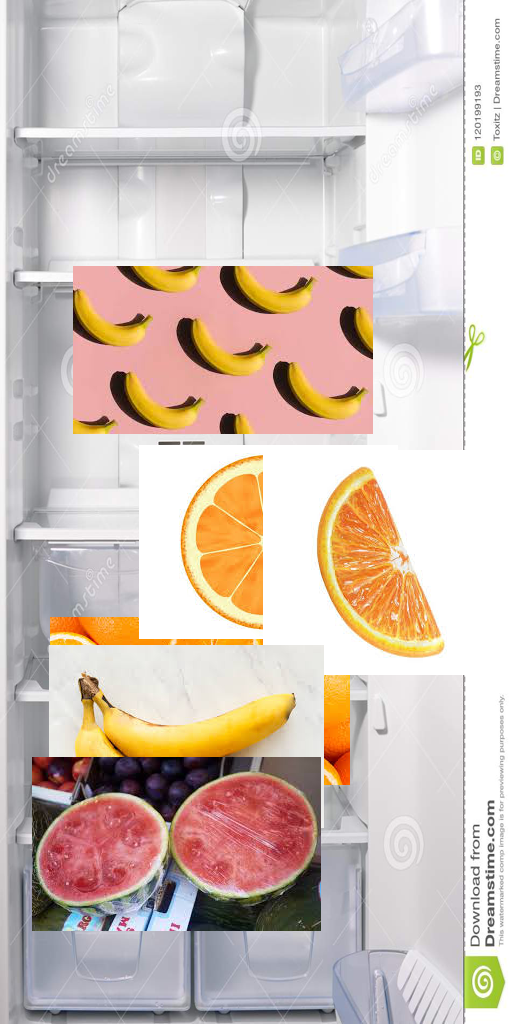

In [42]:
bg

['orange', 'banana', 'watermelon']